En este script, se compara los rendimientos generados por los distintos modelos entrenados anteriormente.

Primero, se importan las librerías necesarias

In [16]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Se definen los directorios que se van a emplear

In [17]:
CWD = os.getcwd()
TEST_DATA_PATH = os.path.join(CWD, "dataset", "test")

# Ruta donde se guardaron los entrenamientos del paso anterior
PROJECT_PATH = os.path.join(CWD, "runs")

# Modelos a evaluar
variants = ['n', 's', 'm']

df = pd.read_csv("full_dataset/ISIC_2019_Training_GroundTruth.csv")
df = df.drop("UNK", axis=1)

target_names = sorted([c for c in df.columns[1:]])
target_names

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

## Rendimiento del entrenamiento

Durante el entrenamiento, Yolo genera automáticamente gráficas con el rendimiento de cada paso. Se procede a mostrar dichas gráfiacas para comparar el comportamiento de los modelos en el entrenamiento

Gráficas de entrenamiento de yolo11n-cls:


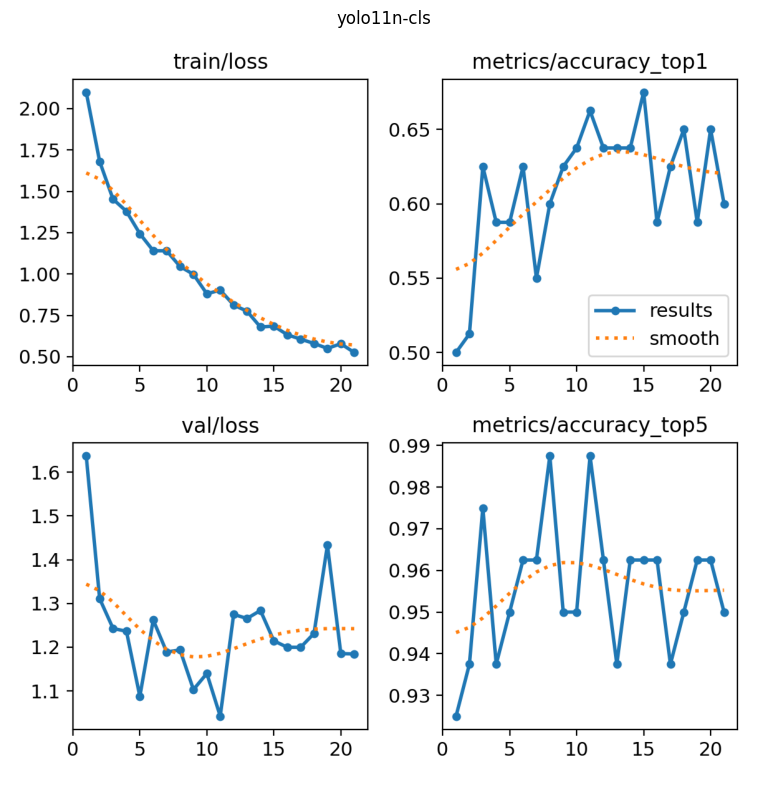

Gráficas de entrenamiento de yolo11s-cls:


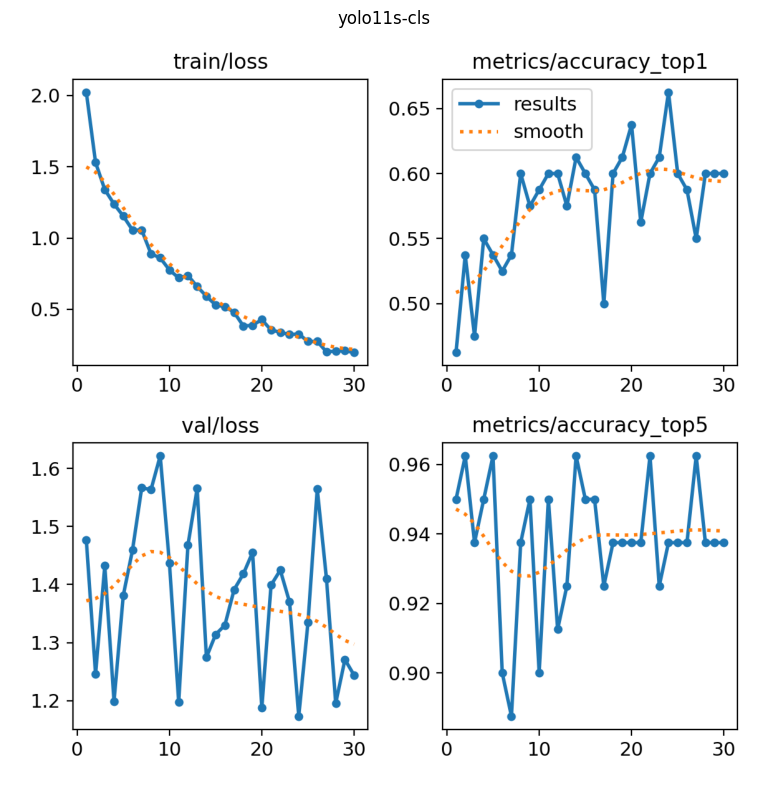

Gráficas de entrenamiento de yolo11m-cls:


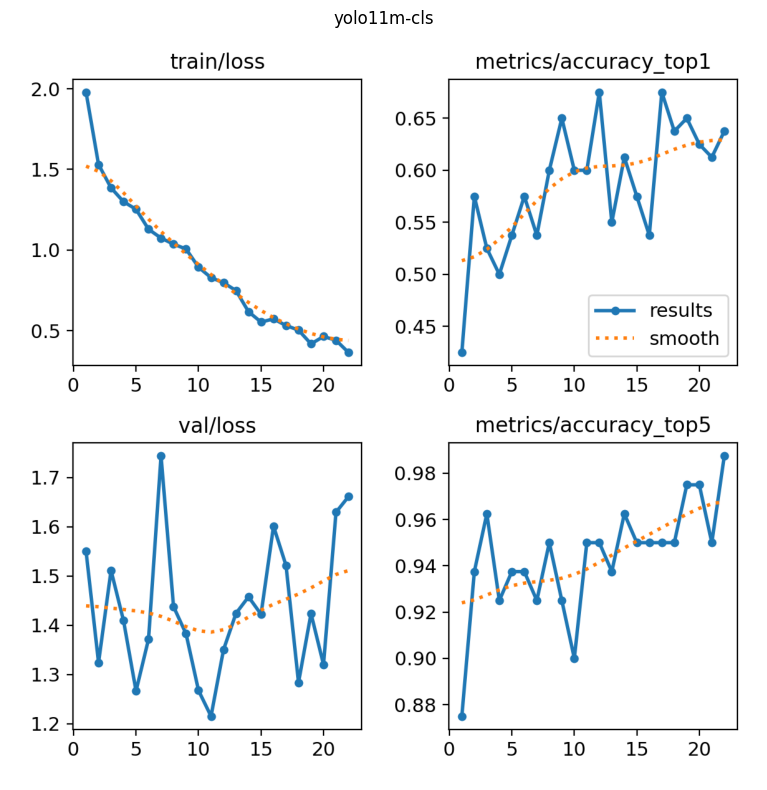

In [18]:
models = ["yolo11n-cls.pt", "yolo11s-cls.pt", "yolo11m-cls.pt"]

for name in models:
    model_path = os.path.join(PROJECT_PATH, f"train_{name}")
    
    if not os.path.exists(model_path):
        print(f"No existe la carpeta: {model_path}")
        continue
        
    # Display results for the model
    print(f"Gráficas de entrenamiento de {name.replace(".pt", "")}:")
    results = os.path.join(model_path, "results.png")

    _, ax = plt.subplots(figsize=(8, 8))
    img = Image.open(results)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{name.replace(".pt", "")}")
    plt.tight_layout()
    plt.show()

## Rendimiento en la predicción

En el proceso de predicción también se generaron las métricas de rendimiento, como la matriz de confusión, accuracy, precisión etc. Se va a mostrar dichas métricas y a compararlas entre ellas